##  Case Study


The purpose of this case study is to analysis the data sample and answer the following questions.
1. Create five tiers for agent size based on the sample dataset provided such that 
   * approx 20%, 45%, 20%, 10%, and 5% of agents fall into a tier
   * the tiers are as attractive as possible (ex 100GB, not 101.33GB)
   * no more than 10% agents are likely to move up a tier or more within 12 months

2. Are there any natural breakpoints in agent size that we should consider for tiering purposes, even if it contradicts the percentages in 1a. (i)
<br>

3. Each agent serves a single purposes on a device, called a workload. Additionally, each agent has a specific Retention Type (ICR, TBR). It is believed that the distribution of workloads for all ICR agents is equivalent to the distribution of workloads for all TBR agents. Does this data support this belief?
<br>

4. Are there any other interesting findings in this dataset you'd like to highligh/call out areas worth investigating further?

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

### Data Exploration:

In [215]:
# read the file and study the general output about the dataframe
datto = pd.read_csv('datta.csv')
print(datto.info())
datto.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product Model         5000 non-null   object 
 1   Device Capacity (GB)  5000 non-null   float64
 2   Retention             5000 non-null   object 
 3   Country               5000 non-null   object 
 4   Device ID             5000 non-null   int64  
 5   Agent ID              5000 non-null   int64  
 6   Workload              5000 non-null   object 
 7   Month 1 Size (GB)     5000 non-null   float64
 8   Month 2 Size (GB)     5000 non-null   float64
 9   Month 3 Size (GB)     5000 non-null   float64
 10  Month 12 Size (GB)    5000 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 429.8+ KB
None


,Product Model,Device Capacity (GB),Retention,Country,Device ID,Agent ID,Workload,Month 1 Size (GB),Month 2 Size (GB),Month 3 Size (GB),Month 12 Size (GB)
0,G,1024.0,TBR,US,2949,1,domainController,209.9,245.5,292.8,320.2
1,AM,512.0,TBR,GB,3496,2,domainController,319.2,330.0,293.6,355.2
2,BR,2048.0,TBR,US,4468,3,domainController,158.7,157.5,162.2,265.3
3,BR,2048.0,TBR,US,4468,4,vm,21.0,14.9,21.2,24.5
4,BR,2048.0,TBR,US,4468,5,vm,19.8,18.9,21.5,24.5


In [216]:
#let's generate the the basic statistical characteristics of each numerical feature, missing value, mean, std, range and quartles
datto.describe()

,Device Capacity (GB),Device ID,Agent ID,Month 1 Size (GB),Month 2 Size (GB),Month 3 Size (GB),Month 12 Size (GB)
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8853.241880,49652.762600,2500.500000,281.540760,318.574440,335.888520,396.345440
std,10358.010292,10777.276473,1443.520003,665.368673,713.131772,773.180393,827.464368
min,512.000000,2949.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2048.000000,44330.000000,1250.750000,27.300000,38.400000,44.400000,54.875000
50%,5120.000000,53927.000000,2500.500000,59.900000,79.100000,88.000000,117.700000
75%,10240.000000,57758.000000,3750.250000,232.025000,283.400000,298.100000,376.525000
max,61440.000000,61515.000000,5000.000000,9321.800000,14268.600000,19680.700000,13949.600000


In [217]:
print(datto.describe(include='object'))
print('\n')
print(datto.isnull().sum())


       Product Model Retention Country          Workload
count           5000      5000    5000              5000
unique            76         2      18                14
top               AW       TBR      US  domainController
freq             512      4144    4231              1683


Product Model           0
Device Capacity (GB)    0
Retention               0
Country                 0
Device ID               0
Agent ID                0
Workload                0
Month 1 Size (GB)       0
Month 2 Size (GB)       0
Month 3 Size (GB)       0
Month 12 Size (GB)      0
dtype: int64


### Tiering 

After looking into each column of the sample dataset, I assumed that 'Device Capacity (GB)' is a potential column that can be used to breakdown the sample data into five different tiers. Also, my assumption is that companys generally charge storage based on storage tiers rather than the storage usage. 

In [218]:
#generate a frequency table of Device Capacity (GB)
capacity_frequency = datto['Device Capacity (GB)'].value_counts(normalize=True).sort_index()
print(capacity_frequency)
print('\n')
print("min:",datto['Device Capacity (GB)'].min())
print('max:', datto['Device Capacity (GB)'].max())
print(capacity_frequency.sum())

512.0      0.0172
880.7      0.0004
1024.0     0.1176
2048.0     0.1620
3072.0     0.0768
4096.0     0.0670
5120.0     0.0974
6144.0     0.0816
8192.0     0.0010
9216.0     0.0002
10240.0    0.1492
12288.0    0.0844
13312.0    0.0012
15360.0    0.0032
18432.0    0.0222
20480.0    0.0046
21504.0    0.0376
24576.0    0.0146
36864.0    0.0456
40960.0    0.0048
49152.0    0.0006
61440.0    0.0108
Name: Device Capacity (GB), dtype: float64


min: 512.0
max: 61440.0
1.0


In [221]:
#creata frequency tier 
def find_tier(row):
    if row['Device Capacity (GB)'] <=2000:
        return 'Tier 1 (0-2000)'
    elif 2001<=row['Device Capacity (GB)'] <=9000:
        return 'Tier 2 (2000-9000)'
    elif 9001<=row['Device Capacity (GB)']<=13000:
        return 'Tier 3 (9000-13000)'
    elif 13001 <=row['Device Capacity (GB)']<=25000:
        return 'Tier 4 (13000-25000)'
    else:
        return 'Tier 5 (25000 and above)'
datto['Tier']=datto.apply(find_tier, axis=1)

tiers = datto['Tier'].value_counts().sort_index().rename_axis('Tier').reset_index(name='count')
#total = len(datto)
print(total)
tiers['percentage']=(tiers['count']/len(datto))*100
tiers

    

5000


,Tier,count,percentage
0,Tier 1 (0-2000),676,13.52
1,Tier 2 (2000-9000),2429,48.58
2,Tier 3 (9000-13000),1169,23.38
3,Tier 4 (13000-25000),417,8.34
4,Tier 5 (25000 and above),309,6.18


In [225]:
# Q1.c since the dataset shouldn't have more than 10% of data that is likely to move up tiers within 12 months
datto['capacity_usage_percent']= (datto['Month 12 Size (GB)']/datto['Device Capacity (GB)'])*100
capacity_usage = datto[datto['capacity_usage_percent']>70].count()[0]
above_70 = datto[datto['capacity_usage_percent']>70]
print("# of rows having capacity_usage >70%:", capacity_usage)
print("percentage of data consisting of capacity_usage_percent >70:", (capacity_usage/len(datto))*100)
#above_70 = datto[datto['capacity_usage_percent']>70]
above_70

# of rows having capacity_usage >70%: 19
percentage of data consisting of capacity_usage_percent >70: 0.38


,Product Model,Device Capacity (GB),Retention,Country,Device ID,Agent ID,Workload,Month 1 Size (GB),Month 2 Size (GB),Month 3 Size (GB),Month 12 Size (GB),capacity_usage_percent,Tier
67,I,2048.0,TBR,US,16836,68,domainController,1123.8,1526.9,1156.7,1563.6,76.347656,Tier 2 (2000-9000)
157,AQ,512.0,TBR,US,24704,158,domainController,271.2,292.0,295.5,361.3,70.566406,Tier 1 (0-2000)
202,AQ,512.0,TBR,US,26480,203,fileserver,236.5,351.4,362.6,391.4,76.445312,Tier 1 (0-2000)
462,BD,1024.0,TBR,US,33383,463,fileserver,603.5,571.0,578.2,804.2,78.535156,Tier 1 (0-2000)
1463,BU,2048.0,TBR,CA,46191,1464,domainController,808.8,961.6,1282.7,1537.0,75.048828,Tier 2 (2000-9000)
1465,BG,5120.0,TBR,US,46206,1466,fileserver,3683.6,3879.0,4048.0,3715.1,72.560547,Tier 2 (2000-9000)
1627,AO,1024.0,TBR,CA,47288,1628,domainController,494.0,548.9,589.5,822.1,80.283203,Tier 1 (0-2000)
1774,BW,3072.0,TBR,US,48061,1775,fileserver,2130.1,2153.0,2160.0,2339.6,76.158854,Tier 2 (2000-9000)
2011,AQ,512.0,TBR,US,49633,2012,domainController,345.2,367.1,366.5,411.1,80.292969,Tier 1 (0-2000)
2029,BW,3072.0,TBR,US,49682,2030,domainController,1615.7,1769.3,1784.5,2258.5,73.518880,Tier 2 (2000-9000)


* It appears there is 0.38% of data, which is likely to move up tiers within 12 months. I assumed the possibilty of moving up on tiers depend on data usage (>70%). The data usage is calculated as '12 month size'/'device capacity'. This consists only 0.38% of the dataset, we wouldn't remove these rows.


### Natural Breakpoint using bins

The dataset is breakdown into five tiers using bins and equal intervals

In [157]:
#natural tiering 
natural_tiering = datto['Device Capacity (GB)'].value_counts(bins=5).sort_index()
natural_tiering

(451.071, 12697.6]    4274
(12697.6, 24883.2]     417
(24883.2, 37068.8]     228
(37068.8, 49254.4]      27
(49254.4, 61440.0]      54
Name: Device Capacity (GB), dtype: int64

In [258]:
intervals = pd.interval_range(start=0, end=65000, freq=12500)
natural_tiers= pd.Series([0,0,0,0,0], index=intervals)
for value in datto['Device Capacity (GB)']:
    for interval in intervals:
        if value in interval:
            natural_tiers.loc[interval]+=1
            break
#print(type(natural_tiers))

natural_tiers = pd.DataFrame(natural_tiers)
natural_tiers.reset_index()
natural_tiers.columns=['count']

#natural_tiers.columns='count'
natural_tiers['percentage']=(natural_tiers['count']/len(datto))*100
print("Natural Tiering using 5 bins")
natural_tiers





Natural Tiering using 5 bins


,count,percentage
"(0, 12500]",4274,85.48
"(12500, 25000]",417,8.34
"(25000, 37500]",228,4.56
"(37500, 50000]",27,0.54
"(50000, 62500]",54,1.08


In equal interval tiering, about 85% of the dataset is clustered into 1st Tier (0, 13000) with interval of 13000. This tier model contradicts the previous tier model. It might affect the pricing strategy because most of dataset is clustered into 1st Tier and only 8% of dataset is clustered in Tier 2 (13000, 26000)

### Q2.  Checking Distribution of Retention Category
The distribution graphs for retention ICR and TBR are ploted using normal distribution


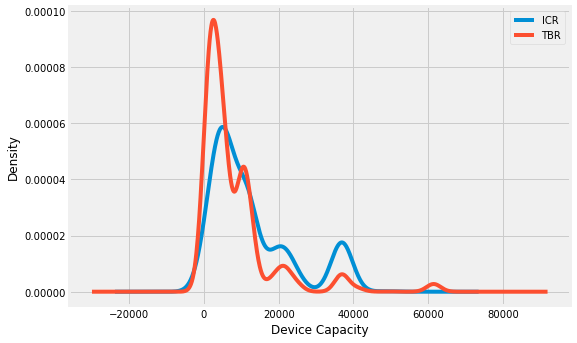

In [211]:
dist_1 = datto[datto['Retention']=='ICR']
dist_2 = datto[datto['Retention']=='TBR']
%matplotlib inline

#plt.style.use('fivethirtyeight')
dist_1['Device Capacity (GB)'].plot.kde(figsize=(8,5.5), label='ICR', legend=True)
dist_2['Device Capacity (GB)'].plot.kde(label='TBR', legend=True)
plt.xlabel('Device Capacity')
plt.show()

In [160]:
dist_1['Device Capacity (GB)'].value_counts(normalize=True).sort_index()*100

512.0       0.584112
1024.0      3.738318
2048.0      7.827103
3072.0      2.570093
4096.0     11.448598
5120.0      4.205607
6144.0     17.757009
10240.0    10.397196
12288.0    14.135514
18432.0     5.140187
21504.0     7.009346
24576.0     2.336449
36864.0    12.616822
40960.0     0.116822
49152.0     0.116822
Name: Device Capacity (GB), dtype: float64

In [161]:
dist_2['Device Capacity (GB)'].value_counts(normalize=True).sort_index()*100

512.0       1.954633
880.7       0.048263
1024.0     13.416988
2048.0     17.929537
3072.0      8.735521
4096.0      5.719112
5120.0     10.883205
6144.0      6.177606
8192.0      0.120656
9216.0      0.024131
10240.0    15.854247
12288.0     7.263514
13312.0     0.144788
15360.0     0.386100
18432.0     1.616795
20480.0     0.555019
21504.0     3.088803
24576.0     1.278958
36864.0     2.895753
40960.0     0.555019
49152.0     0.048263
61440.0     1.303089
Name: Device Capacity (GB), dtype: float64

In [162]:
mean_dist1 = dist_1['Device Capacity (GB)'].mean()
mean_dist2 = dist_2['Device Capacity (GB)'].mean()
mode_dist1 = dist_1['Device Capacity (GB)'].mode()[0]
mode_dist2 = dist_2['Device Capacity (GB)'].mode()[0]
median_dist1= dist_1['Device Capacity (GB)'].median()
median_dist2 = dist_2['Device Capacity (GB)'].median()
std_dist1 = dist_1['Device Capacity (GB)'].std(ddof=1)
std_dist2= dist_2['Device Capacity (GB)'].std(ddof=1)

summary = pd.DataFrame()
summary['ICR']=[mean_dist1, median_dist1, mode_dist1, std_dist1]
summary['TBR']=[mean_dist2, median_dist2, mode_dist2, std_dist2]
summary.index=['mean', 'median', 'mode', 'std']
summary

,ICR,TBR
mean,12642.691589,8070.479102
median,10240.000000,5120.000000
mode,6144.000000,2048.000000
std,11095.809383,10023.366062


#### Distribution for the workload

In [163]:
icr_distribution = dist_1['Workload'].value_counts(normalize=True).rename_axis('workload').reset_index(name='counts')

print(icr_distribution)

tbr_distribution = dist_2['Workload'].value_counts(normalize=True).rename_axis('workload').reset_index(name='counts')

            workload    counts
0   domainController  0.275701
1         fileserver  0.209112
2           database  0.127336
3           terminal  0.117991
4        application  0.113318
5         mailserver  0.049065
6          webserver  0.039720
7                 vm  0.017523
8              print  0.017523
9             citrix  0.011682
10             phone  0.010514
11               rdp  0.007009
12               fax  0.002336
13               cad  0.001168


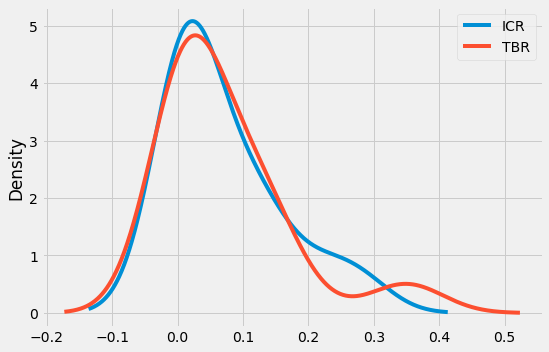

In [164]:
icr_distribution['counts'].plot.kde(figsize=(8,5.5), label='ICR', legend=True)
tbr_distribution['counts'].plot.kde(label='TBR', legend=True)
plt.show()


In [212]:
icr_mean =icr_distribution['counts'].mean()
icr_mode = icr_distribution['counts'].mode()[0]
icr_median=icr_distribution['counts'].median()
tbr_mean = tbr_distribution['counts'].mean()
tbr_mode = tbr_distribution['counts'].mode()[0]
tbr_median = tbr_distribution['counts'].median()
icr_std = icr_distribution['counts'].std(ddof=1)
tbr_std = tbr_distribution['counts'].std(ddof=1)

summary2= pd.DataFrame()
summary2['ICR']=[icr_mean, icr_mode, icr_median, icr_std]
summary2['TBR']=[tbr_mean, tbr_mode, tbr_median, tbr_std]
summary2.index=['mean', 'mode', 'median', 'std']
summary2

,ICR,TBR
mean,0.071429,0.071429
mode,0.017523,0.008446
median,0.028621,0.026786
std,0.086019,0.095652


### Interesting Findings

There are few other areas that are worth investigating furthure. For instances, Device Capacity can be groupbed by country and see how the total capacity is allocated and its top countries.

In [231]:
#device capacity is grouped by the country
country_allocation = pd.pivot_table(datto, index='Country', values=['Device Capacity (GB)', 'Month 12 Size (GB)', 'Agent ID'], 
                                    aggfunc={'Device Capacity (GB)':np.sum,
                                             'Month 12 Size (GB)': np.sum,
                                             'Agent ID': len})
#.rename_axis('workload').reset_index(name='counts')
country_allocation['total_usage']=(country_allocation['Month 12 Size (GB)']/country_allocation['Device Capacity (GB)'])*100
country_allocation.sort_values('Device Capacity (GB)', ascending=False)


,Agent ID,Device Capacity (GB),Month 12 Size (GB),total_usage
Country,,,,
US,4231,38458880.0,1678600.4,4.364663
CA,373,2990817.4,147788.3,4.941402
GB,193,1473024.0,81620.1,5.540989
AU,135,739328.0,41147.8,5.565568
MX,11,136192.0,6215.6,4.563851
PA,10,122880.0,3849.4,3.132650
PE,10,122880.0,5356.1,4.358805
NO,3,55296.0,220.0,0.397859
DO,7,38912.0,4633.6,11.907895


In [241]:
work_load = pd.pivot_table(datto, index='Workload', values=['Device Capacity (GB)', 'Agent ID', 'Month 12 Size (GB)'], 
                           aggfunc={'Device Capacity (GB)':np.sum,
                                    'Agent ID': len,
                                    'Month 12 Size (GB)': np.sum})
work_load['total_usage']=(work_load['Month 12 Size (GB)']/work_load['Device Capacity (GB)'])*100
work_load.sort_values('Month 12 Size (GB)', ascending=False)

,Agent ID,Device Capacity (GB),Month 12 Size (GB),total_usage
Workload,,,,
fileserver,821,8810864.7,807662.0,9.166660
domainController,1683,11542896.7,468903.3,4.062267
database,638,6320640.0,265571.7,4.201658
mailserver,231,2113536.0,156339.4,7.397054
application,578,5299200.0,131864.2,2.488379
terminal,523,4131840.0,85755.7,2.075485
webserver,191,2509824.0,18688.1,0.744598
vm,63,309760.0,14493.6,4.678977
rdp,71,587776.0,10695.8,1.819707


#### Monthly Usage Trend

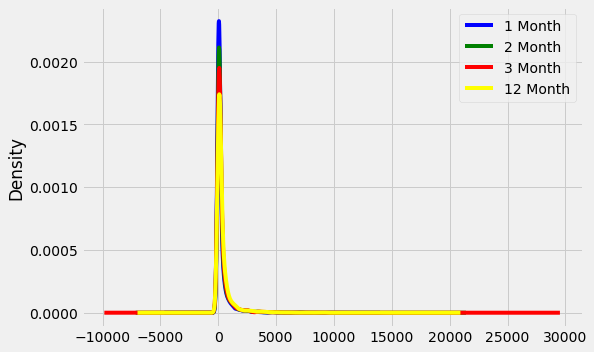

In [248]:
datto['Month 1 Size (GB)'].plot.kde(figsize=(8,5.5), label='1 Month', legend=True, color='blue')
datto['Month 2 Size (GB)'].plot.kde(label='2 Month', legend=True, color='green')
datto['Month 3 Size (GB)'].plot.kde(label='3 Month', legend=True, color='red')
datto['Month 12 Size (GB)'].plot.kde(label='12 Month', legend=True, color='yellow')

#plt.xlim(-100, 14000)


In [250]:
print('Month 1 mean:', datto['Month 1 Size (GB)'].mean())
print('Month 1 std:', datto['Month 1 Size (GB)'].std(ddof=1))
print('Month 2 mean:', datto['Month 2 Size (GB)'].mean())
print('Month 2 std:', datto['Month 2 Size (GB)'].std(ddof=1))
print('Month 3 mean:', datto['Month 3 Size (GB)'].mean())
print('Month 3 std:', datto['Month 3 Size (GB)'].std(ddof=1))
print('Month 12 mean:', datto['Month 12 Size (GB)'].mean())
print('Month 12 std:', datto['Month 12 Size (GB)'].std(ddof=1))




Month 1 mean: 281.5407600000005
Month 1 std: 665.3686725002107
Month 2 mean: 318.5744399999999
Month 2 std: 713.1317722662535
Month 3 mean: 335.8885199999992
Month 3 std: 773.1803925657309
Month 12 mean: 396.3454400000002
Month 12 std: 827.4643682886682


(array([1, 2, 3, 4]), <a list of 4 Text major ticklabel objects>)

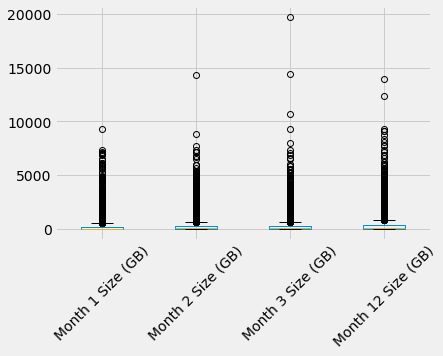

In [257]:
datto.boxplot(column=['Month 1 Size (GB)', 'Month 2 Size (GB)', 'Month 3 Size (GB)', 'Month 12 Size (GB)'])
plt.xticks(rotation=45)

